In [1]:
import os, glob
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

DATA_DIR = "data/multi_resolution"
SEQ_LEN = 64

FEATURE_COLS = ["open", "high", "low", "close", "r"]

CLASSES = [
  'BearBat','BearButterfly','BearCrab','BearCypher','BearGartley','BearShark',
  'BullBat','BullButterfly','BullCrab','BullCypher','BullGartley','BullShark'
]
class_to_id = {c:i for i,c in enumerate(CLASSES)}
num_classes = len(CLASSES)

MAX_SEQS_PER_FILE = None   # optionally set e.g. 2000 to cap memory/time
MIN_GROUP_LEN = 1

JUNK_COLS = {"Unnamed: 0", "Unnamed:0", "index", "level_0"}
REQUIRED_COLS = {"date", "open", "high", "low", "close", "r", "pattern"}

In [3]:
# file lists
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.csv")))

EVAL_FILES = [
    os.path.join(DATA_DIR, "1hour_sigma0.01.csv"),
    os.path.join(DATA_DIR, "1minute_sigma0.005.csv"),
    os.path.join(DATA_DIR, "1day_sigma0.02.csv"),
]
train_files = [f for f in all_files if f not in EVAL_FILES]

print("Found files:", len(all_files))
print("Train files:", len(train_files))
print("Eval files:", len(EVAL_FILES))
print(
    "Overlap(train, eval) =",
    set(map(os.path.basename, train_files)).intersection(set(map(os.path.basename, EVAL_FILES)))
)

Found files: 17
Train files: 14
Eval files: 3
Overlap(train, eval) = set()


In [4]:
# loading
def load_and_clean_csv(path: str) -> pd.DataFrame:
    cols = pd.read_csv(path, nrows=0).columns.tolist()
    cols = [c for c in cols if c not in JUNK_COLS]
    usecols = [c for c in cols if c in REQUIRED_COLS]

    df = pd.read_csv(path, usecols=usecols)
    df = df.drop(columns=[c for c in df.columns if c in JUNK_COLS], errors="ignore")

    missing = REQUIRED_COLS - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

    for c in FEATURE_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["r"] = df["r"].fillna(0.0)
    df = df.dropna(subset=["open", "high", "low", "close"])

    allowed = set(CLASSES) | {"no-pattern"}
    df = df[df["pattern"].isin(allowed)].copy()

    return df

In [5]:
def df_to_sequences(df: pd.DataFrame):
    # Drop no-pattern for this classification task (12 classes)
    df = df[df["pattern"] != "no-pattern"].copy()
    if len(df) == 0:
        return None, None

    # Group consecutive identical patterns
    df["group_id"] = (df["pattern"] != df["pattern"].shift(1)).cumsum()

    X_list, y_list = [], []

    for _, g in df.groupby("group_id"):
        label = g["pattern"].iloc[0]
        if label not in class_to_id:
            continue

        feat = g[FEATURE_COLS].values.astype(np.float32)
        if len(feat) < MIN_GROUP_LEN:
            continue

        # fixed-length window via pad/truncate (pad with zeros)
        if len(feat) >= SEQ_LEN:
            seq = feat[-SEQ_LEN:]
        else:
            pad_len = SEQ_LEN - len(feat)
            pad = np.zeros((pad_len, feat.shape[1]), dtype=np.float32)
            seq = np.concatenate([pad, feat], axis=0)

        X_list.append(seq)
        y_list.append(class_to_id[label])

        if MAX_SEQS_PER_FILE is not None and len(X_list) >= MAX_SEQS_PER_FILE:
            break

    if len(X_list) == 0:
        return None, None

    X = np.stack(X_list)  # (n_seq, SEQ_LEN, n_feat)
    y = np.array(y_list, dtype=np.int64)
    return X, y



In [6]:
# print label distribution separately for train/eval
def print_label_distribution(file_list, title: str):
    total = Counter()
    for path in file_list:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences(df)
        if y is None:
            continue
        total.update(y.tolist())
    inv = {v: k for k, v in class_to_id.items()}
    print(f"\n{title} label distribution (sequence-level):")
    for k, v in total.most_common():
        print(f"  {inv[k]}: {v}")
    print("  Total sequences:", sum(total.values()))

print_label_distribution(train_files, "TRAIN")
print_label_distribution(EVAL_FILES, "EVAL")

# fit scaler on TRAIN only (ignore padded rows)
scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(path)
    X, y = df_to_sequences(df)
    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0, axis=1))  # ignore padded rows
    if nonpad.any():
        scaler.partial_fit(Xp[nonpad])

def scale_X_keep_padding_zero(X: np.ndarray) -> np.ndarray:
    """
    Scale non-padding rows with global scaler; keep padded (all-zero) rows as zeros.
    """
    s, t, f = X.shape
    X2 = X.reshape(-1, f)

    pad_mask = np.all(X2 == 0, axis=1)
    X2_scaled = X2.copy()
    if (~pad_mask).any():
        X2_scaled[~pad_mask] = scaler.transform(X2[~pad_mask])

    return X2_scaled.reshape(s, t, f).astype(np.float32)




TRAIN label distribution (sequence-level):
  BearButterfly: 42121
  BullButterfly: 40781
  BearGartley: 38614
  BullGartley: 37652
  BearShark: 30304
  BullShark: 30172
  BullCypher: 16431
  BearCypher: 15460
  BullBat: 15424
  BullCrab: 14845
  BearBat: 13687
  BearCrab: 13544
  Total sequences: 309035

EVAL label distribution (sequence-level):
  BearButterfly: 5495
  BullButterfly: 5364
  BearGartley: 4979
  BullGartley: 4880
  BearShark: 3933
  BullShark: 3620
  BullCypher: 2176
  BearCypher: 2081
  BullBat: 1658
  BullCrab: 1635
  BearBat: 1470
  BearCrab: 1457
  Total sequences: 38748


In [7]:
# build dataset
def build_dataset_from_files(file_list):
    X_list, y_list = [], []
    for path in file_list:
        df = load_and_clean_csv(path)
        X, y = df_to_sequences(df)
        if X is None:
            continue
        X = scale_X_keep_padding_zero(X)
        X_list.append(X)
        y_list.append(y)

    if len(X_list) == 0:
        raise ValueError("No sequences were found in the provided files.")

    X_all = np.concatenate(X_list, axis=0)  # (N, SEQ_LEN, F)
    y_all = np.concatenate(y_list, axis=0)  # (N,)
    return X_all, y_all

X_train_seq, y_train = build_dataset_from_files(train_files)
X_eval_seq,  y_eval  = build_dataset_from_files(EVAL_FILES)

print("\nTrain seq shape:", X_train_seq.shape, y_train.shape)
print("Eval  seq shape:", X_eval_seq.shape,  y_eval.shape)

# flatten for SVM
Ntr, T, F = X_train_seq.shape
Nev = X_eval_seq.shape[0]

X_train_flat = X_train_seq.reshape(Ntr, T * F)
X_eval_flat  = X_eval_seq.reshape(Nev, T * F)

print("Train flat shape:", X_train_flat.shape)
print("Eval  flat shape:", X_eval_flat.shape)




Train seq shape: (309035, 64, 5) (309035,)
Eval  seq shape: (38748, 64, 5) (38748,)
Train flat shape: (309035, 320)
Eval  flat shape: (38748, 320)


In [8]:
# train + evaluate linear SVM 
svm = LinearSVC(
    C=1.0,
    class_weight="balanced",
    max_iter=20000,
    random_state=42
)

svm.fit(X_train_flat, y_train)
y_pred = svm.predict(X_eval_flat)

               precision    recall  f1-score   support

      BearBat       0.12      0.31      0.17      1470
BearButterfly       0.27      0.08      0.12      5495
     BearCrab       0.09      0.32      0.15      1457
   BearCypher       0.11      0.05      0.07      2081
  BearGartley       0.21      0.37      0.27      4979
    BearShark       0.17      0.04      0.06      3933
      BullBat       0.12      0.28      0.17      1658
BullButterfly       0.28      0.09      0.14      5364
     BullCrab       0.11      0.27      0.15      1635
   BullCypher       0.14      0.10      0.12      2176
  BullGartley       0.20      0.25      0.22      4880
    BullShark       0.18      0.02      0.03      3620

     accuracy                           0.16     38748
    macro avg       0.17      0.18      0.14     38748
 weighted avg       0.20      0.16      0.14     38748

Eval files: ['1hour_sigma0.01.csv', '1minute_sigma0.005.csv', '1day_sigma0.02.csv']
Overlap(train, eval) = set()


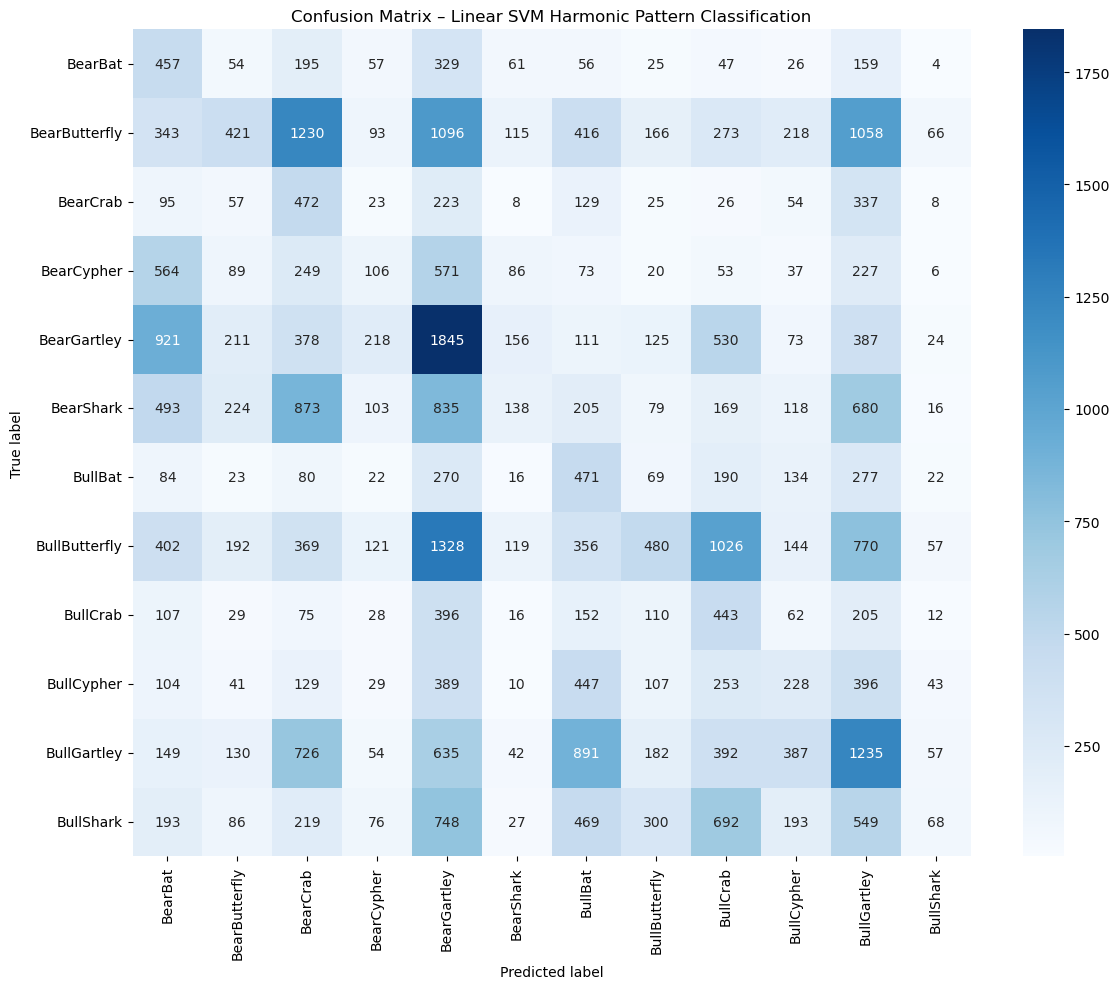

In [9]:
print(
    classification_report(
        y_eval,
        y_pred,
        labels=np.arange(num_classes),
        target_names=CLASSES,
        zero_division=0
    )
)

print("Eval files:", [os.path.basename(p) for p in EVAL_FILES])

# Ensure no leakage
train_set = set(map(os.path.basename, train_files))
eval_set  = set(map(os.path.basename, EVAL_FILES))
print("Overlap(train, eval) =", train_set.intersection(eval_set))

# Confusion Matrix
cm = confusion_matrix(
    y_eval,
    y_pred,
    labels=np.arange(num_classes)
)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Linear SVM Harmonic Pattern Classification")
plt.tight_layout()
plt.show()